In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
LR=5e-3

transform_train = transforms.Compose([
    #transforms.RandomCrop(24, padding=4),
    #transforms.RandomRotation(degrees=(0, 180)), 
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=False, num_workers=4)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=4)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [3]:
def plot_images(images, labels, classes, normalize = False):
    n_images = len(images)
    rows = 2
    cols = int(n_images/2)
    fig = plt.figure(figsize = (20, 8))
    
    for i in range(n_images):
        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        if torch.is_tensor(image):
          ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        else:
          ax.imshow(image)
        
        ax.set_title(classes[labels[i]])
        ax.axis('off')

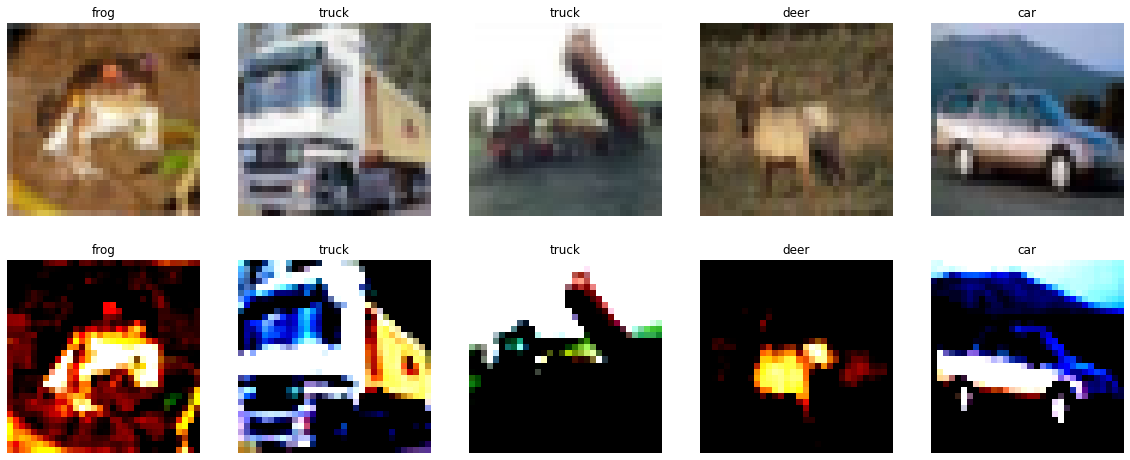

In [4]:
N_IMAGES = 10

images = [trainset.data[i] for i in range(int(N_IMAGES/2))]

augImages = []
labels = []

for batch in trainloader:
  for i in range(int(N_IMAGES/2)):
    labels.append(batch[1][i])
    augImages.append(batch[0][i])
  break

images+=augImages
labels+=labels

plot_images(images, labels, classes, normalize = False)

In [5]:
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=4)

In [6]:
class SE(nn.Module):
    '''Squeeze-and-Excitation block.'''

    def __init__(self, in_planes, se_planes):
        super(SE, self).__init__()
        self.se1 = nn.Conv2d(in_planes, se_planes, kernel_size=1, bias=True)
        self.se2 = nn.Conv2d(se_planes, in_planes, kernel_size=1, bias=True)

    def forward(self, x):
        out = F.adaptive_avg_pool2d(x, (1, 1))
        out = F.relu(self.se1(out))
        out = self.se2(out).sigmoid()
        out = x * out
        return out


class Block(nn.Module):
    def __init__(self, w_in, w_out, stride, group_width, bottleneck_ratio, se_ratio):
        super(Block, self).__init__()
        # 1x1
        w_b = int(round(w_out * bottleneck_ratio))
        self.conv1 = nn.Conv2d(w_in, w_b, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(w_b)
        # 3x3
        num_groups = w_b // group_width
        self.conv2 = nn.Conv2d(w_b, w_b, kernel_size=3,
                               stride=stride, padding=1, groups=num_groups, bias=False)
        self.bn2 = nn.BatchNorm2d(w_b)
        # se
        self.with_se = se_ratio > 0
        if self.with_se:
            w_se = int(round(w_in * se_ratio))
            self.se = SE(w_b, w_se)
        # 1x1
        self.conv3 = nn.Conv2d(w_b, w_out, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(w_out)

        self.shortcut = nn.Sequential()
        if stride != 1 or w_in != w_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(w_in, w_out,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(w_out)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        if self.with_se:
            out = self.se(out)
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class RegNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(RegNet, self).__init__()
        self.cfg = cfg
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(0)
        self.layer2 = self._make_layer(1)
        self.layer3 = self._make_layer(2)
        self.layer4 = self._make_layer(3)
        self.linear = nn.Linear(self.cfg['widths'][-1], num_classes)

    def _make_layer(self, idx):
        depth = self.cfg['depths'][idx]
        width = self.cfg['widths'][idx]
        stride = self.cfg['strides'][idx]
        group_width = self.cfg['group_width']
        bottleneck_ratio = self.cfg['bottleneck_ratio']
        se_ratio = self.cfg['se_ratio']

        layers = []
        for i in range(depth):
            s = stride if i == 0 else 1
            layers.append(Block(self.in_planes, width,
                                s, group_width, bottleneck_ratio, se_ratio))
            self.in_planes = width
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def RegNetX_200MF():
    cfg = {
        'depths': [1, 1, 4, 7],
        'widths': [24, 56, 152, 368],
        'strides': [1, 1, 2, 2],
        'group_width': 8,
        'bottleneck_ratio': 1,
        'se_ratio': 0,
    }
    return RegNet(cfg)


In [7]:
model=RegNetX_200MF().to(device)
print(model)
summary(model, (3, 32, 32))

RegNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
      (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer2): Sequential(

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [9]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        if batch_idx==len(trainloader)-1:
          train_losses.append((train_loss/(batch_idx+1)))
          train_accs.append(100.*correct/total)

def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    sum_loss = 0
    sum_acc = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            sum_loss+=(test_loss/(batch_idx+1))
            sum_acc+=(100.*correct/total)
    test_losses.append(sum_loss/len(testloader))
    test_accs.append(sum_acc/len(testloader))

In [10]:
def milestone(e, x, train_loss, val_loss, train_accuracy, val_accuracy):
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()           # 做镜像处理
    l1 = ax1.plot(x, train_loss, 'lightsalmon', label='train_loss')
    l2 = ax1.plot(x, val_loss, 'red', label='val_loss')
    l3 = ax2.plot(x, train_accuracy, 'c', label='train_accuracy')
    l4 = ax2.plot(x, val_accuracy, 'blue', label='val_accuracy')
    ls = l1+l2+l3+l4
    labels = [l.get_label() for l in ls]
    ax1.legend(ls, labels, loc=7)
    ax1.set_xlabel('training step')    #设置x轴标题
    ax1.set_ylabel('loss',color = 'red')   #设置Y1轴标题
    ax2.set_ylabel('accuracy',color = 'blue')   #设置Y2轴标题
    plt.savefig('./plot_epoch='+str(e)+'.png', dpi=300)
    print('---Epoch', e, 'data saved!---')

In [ ]:
start_epoch=0
train_losses, test_losses, train_accs, test_accs, x=[], [], [], [], []

for epoch in range(start_epoch, start_epoch+20):
    x.append(epoch)
    train(epoch)
    test(epoch)
    scheduler.step()
    milestone(epoch, x, train_losses, test_losses, train_accs, test_accs)


Epoch: 0
0 391 Loss: 2.658 | Acc: 10.156% (13/128)
1 391 Loss: 2.498 | Acc: 10.938% (28/256)
2 391 Loss: 2.496 | Acc: 10.417% (40/384)
3 391 Loss: 2.459 | Acc: 11.328% (58/512)
4 391 Loss: 2.472 | Acc: 11.875% (76/640)
5 391 Loss: 2.466 | Acc: 11.458% (88/768)
6 391 Loss: 2.468 | Acc: 10.714% (96/896)
7 391 Loss: 2.447 | Acc: 11.133% (114/1024)
8 391 Loss: 2.430 | Acc: 12.240% (141/1152)
9 391 Loss: 2.429 | Acc: 12.578% (161/1280)
10 391 Loss: 2.441 | Acc: 13.068% (184/1408)
11 391 Loss: 2.439 | Acc: 13.346% (205/1536)
12 391 Loss: 2.423 | Acc: 13.161% (219/1664)
13 391 Loss: 2.414 | Acc: 13.114% (235/1792)
14 391 Loss: 2.408 | Acc: 12.604% (242/1920)
15 391 Loss: 2.407 | Acc: 12.598% (258/2048)
16 391 Loss: 2.410 | Acc: 12.454% (271/2176)
17 391 Loss: 2.409 | Acc: 12.283% (283/2304)
18 391 Loss: 2.402 | Acc: 12.459% (303/2432)
19 391 Loss: 2.396 | Acc: 12.578% (322/2560)
20 391 Loss: 2.388 | Acc: 12.760% (343/2688)
21 391 Loss: 2.385 | Acc: 12.997% (366/2816)
22 391 Loss: 2.377 | Acc

In [ ]:
print(train_losses, test_losses, train_accs, test_accs, x)